# Supply Chain Disconnect

## 1. Business Context & Motivation

In retail and consumer supply chains, accurate demand forecasting is necessary but not sufficient to ensure high service levels.
Despite stable demand patterns and strong forecasting performance, stockouts continue to occur across multiple SKUs, locations, and suppliers.

Initial analysis indicates that the root cause is supply-side instability, particularly high variability in supplier lead times.
This disconnect between demand planning and supply execution leads to:

* Underestimated safety stock

* Unreliable replenishment cycles

* Lost sales despite correct demand forecasts

This problem cannot be solved by improving demand forecasts alone.

## 2. Problem Statement

How can we proactively detect and mitigate stockout risk caused by unstable supplier lead times, even when demand is stable?

This requires modeling supply uncertainty explicitly and linking it to inventory outcomes.

## 3. Objective

The objectives of this notebook are to:

1. Quantify supplier lead time risk

2. Predict stockout probability in advance

3. Translate model outputs into actionable inventory and procurement decisions

## 4. Modeling Framework Overview

This notebook follows a risk-oriented, modular modeling framework designed specifically for supply chain uncertainty.

Rather than relying on a single predictive model, the framework decomposes the supply chain into interpretable risk components aligned with operational decision-making.

### 4.1 Framework Design Principles

1. **Separation of Demand and Supply Risk**

Demand variability and supply variability are modeled independently to prevent supply issues from being masked by demand noise.

2. **Uncertainty Over Point Estimates**

Variance and distributional behavior are prioritized over average values.

3. **Probability-Based Outputs**

Models produce probabilities and risk scores rather than binary outcomes.

4. **Operational Interpretability**

Every model output corresponds to a concrete business action.

### 4.2 Framework Architecture

```
Data Layer
   ↓
Risk Modeling Layer
   ↓
Decision Support Layer

```
Each layer serves a distinct business purpose.


## 5. Data Layer

The dataset integrates multiple operational dimensions:

* **Demand**: units_sold, promotions, seasonality

* **Inventory**: stock_on_hand, stock_out_flag

* **Supply**: lead_time_days, supplier_id

* **Context**: time, geography, channel, weather

All data is assumed to be cleaned, validated, and time-aligned prior to modeling.

## 6. Problem Decomposition

Stockouts occur due to the interaction of three forces:

1. Demand during replenishment

2. Available inventory buffer

3. Supplier lead time uncertainty

This notebook models each force explicitly.

## 7. Risk Modeling Layer

The risk modeling layer consists of two complementary models.

### 7.1 Model 1 — Supplier Lead Time Risk Model
**Purpose**

To quantify supplier execution uncertainty and detect unstable suppliers.

**Target Variable**

* lead_time_days

**Key Inputs**

* Supplier historical performance

* Location context

* Seasonality signals

* External disruption proxies (weather)

**Outputs**

* Expected lead time

* Lead time volatility

* Supplier reliability indicators

This model informs **safety stock sizing** and **supplier segmentation**.

### 7.2 Model 2 — Stockout Risk Prediction Model
**Purpose**

To predict the probability of stockouts before they occur.

**Target Variable**

* stock_out_flag

**Key Inputs**

* Inventory coverage metrics

* Demand stability indicators

* Lead time risk outputs

* Supplier reliability features


**Outputs**

* Stockout probability

* Risk ranking by SKU–supplier–location

This model powers early warning systems and replenishment prioritization.

## 8. Model Interaction Logic

The two models are interdependent:

* Lead time variability increases stockout probability

* Stockout signals validate supplier instability

* Lead time risk metrics serve as inputs to the stockout model

This reflects real-world causality rather than statistical coincidence.

## 9. Train–Validation Strategy

A time-aware split is used to avoid future leakage:

* Training: historical periods

* Validation: forward periods

* Testing: most recent periods

Random splits are intentionally avoided.

## 10. Evaluation Strategy
### 10.1 Lead Time Model Evaluation

* MAE and RMSE

* Error distribution stability

* Supplier-level residual analysis

### 10.2 Stockout Model Evaluation

* ROC-AUC

* Precision–Recall balance

* Recall on stockout class (business-critical)

The focus is on correctly identifying high-risk scenarios.

## 11. Decision Support Layer

Model outputs are translated into operational actions:

| Signal                    | Business Action        |
| ------------------------- | ---------------------- |
| High lead time variance   | Increase safety stock  |
| High stockout probability | Expedite replenishment |
| Supplier risk spike       | Supplier review        |
| Stable demand & supply    | Inventory optimization |


## 12. Dynamic Safety Stock Implications

Safety stock is adjusted dynamically using:

```
SS = Z × σ_LT × √D

```
Where:

σ_LT = lead time standard deviation

D = average daily demand

Z = service level factor

This ensures buffers scale with uncertainty rather than averages.


## 13. Early Warning System

An early warning system is implemented to flag upcoming risks:

* Lead time spikes beyond thresholds

* Inventory coverage below reorder points

* Supplier reliability deterioration

This enables proactive intervention before stockouts occur.

## 14. Business Impact

The framework enables:

* Reduced stockout frequency

* Improved service levels for high-value SKUs

* Lower emergency procurement costs

* Better supplier accountability

* Stronger S&OP alignment

# Code Implementation

## Imports and Setup

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
np.random.seed(42)


## Load Data


In [3]:
file_path = "/content/fmcg_sales_3years_1M_rows.csv"


df = pd.read_csv(file_path, parse_dates=["date"])
df.sort_values("date", inplace=True)

print(df.shape)
df.head()


(131296, 23)


,date,sku_id,store_id,supplier_id,is_true_baseline,units_sold,promo_flag,stock_out_flag,stock_on_hand,lead_time_days,effective_price,price_index,promo_intensity,lag_units_7,lag_units_28,roll_mean_28d,lt_rolling_mean_30d,lt_rolling_std_30d,supplier_cv,stock_cover_days,required_safety_stock,safety_stock_gap,under_buffered_flag
83608,2021-01-08,SKU0008,STORE0006,S040,1,29,0,0,151,5,3.55,1.0,0.0,20.0,NaN,28.142857,6.733333,2.066704,0.309531,5.365292,101.098340,49.901660,0.0
85784,2021-01-08,SKU0008,STORE0008,S005,1,34,0,0,333,9,3.55,1.0,0.0,27.0,NaN,30.571429,6.000000,1.893728,0.310147,10.892167,95.833999,237.166001,0.0
104782,2021-01-08,SKU0010,STORE0005,S037,1,25,0,0,383,7,7.05,1.0,0.0,44.0,NaN,55.285714,6.833333,1.743626,0.308454,6.927523,188.557444,194.442556,0.0
52935,2021-01-08,SKU0005,STORE0010,S034,1,99,0,0,271,6,9.42,1.0,0.0,183.0,NaN,105.428571,6.666667,1.647011,0.308380,2.570436,338.677182,-67.677182,1.0
82520,2021-01-08,SKU0008,STORE0004,S039,1,18,0,0,222,6,3.55,1.0,0.0,30.0,NaN,27.857143,6.166667,2.364731,0.309050,7.968945,111.875547,110.124453,0.0


## 1. Feature Engineering (Supply-Focused)

### 1.1. Demand Stability Features

In [4]:
# Rolling demand statistics (per SKU-store)
df["avg_daily_demand_7d"] = (
    df.groupby(["sku_id", "store_id"])["units_sold"]
    .transform(lambda x: x.rolling(7, min_periods=3).mean())
)

df["demand_std_7d"] = (
    df.groupby(["sku_id", "store_id"])["units_sold"]
    .transform(lambda x: x.rolling(7, min_periods=3).std())
)


### 1.2. Inventory Coverage

In [5]:
df["inventory_coverage_days"] = (
    df["stock_on_hand"] / (df["avg_daily_demand_7d"] + 1e-5)
)


### 1.3. Supplier Lead Time Risk Features

In [6]:
df["supplier_lt_mean"] = (
    df.groupby("supplier_id")["lead_time_days"]
    .transform("mean")
)

df["supplier_lt_std"] = (
    df.groupby("supplier_id")["lead_time_days"]
    .transform("std")
)

df["supplier_cv"] = df["supplier_lt_std"] / (df["supplier_lt_mean"] + 1e-5)


### 1.4. Lagged Lead Time

In [7]:
df["lead_time_lag_1"] = (
    df.groupby("supplier_id")["lead_time_days"]
    .shift(1)
)


## 2. Encode Categorical Features

In [10]:
#cat_cols = ["supplier_id", "country", "city", "channel", "category", "brand"]
cat_cols = ["supplier_id"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le


## 3. Train–Test Split (Time-Aware)

In [11]:
train = df[df["date"] < "2023-01-01"]
test  = df[df["date"] >= "2023-01-01"]

print(train.shape, test.shape)


(86140, 29) (45156, 29)


## 4. MODEL 1: Supplier Lead Time Prediction

### 4.1. Feature Set

In [13]:
lt_features = [
    "supplier_id",
    #"country",
    #"city",
    #"month",
    #"weekday",
    #"temperature",
    #"rain_mm",
    "supplier_lt_mean",
    "supplier_lt_std",
    "supplier_cv",
    "lead_time_lag_1"
]

train_lt = train.dropna(subset=lt_features + ["lead_time_days"])
test_lt  = test.dropna(subset=lt_features + ["lead_time_days"])


### 4.2. Train Model

In [14]:
lt_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

lt_model.fit(train_lt[lt_features], train_lt["lead_time_days"])


RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

### 4.3 Evaluation

In [15]:
lt_preds = lt_model.predict(test_lt[lt_features])
mae = mean_absolute_error(test_lt["lead_time_days"], lt_preds)

print(f"Lead Time MAE: {mae:.2f} days")


Lead Time MAE: 1.63 days


### 4.4. Lead Time Risk Score

In [16]:
test_lt["predicted_lead_time"] = lt_preds
test_lt["lead_time_risk"] = (
    test_lt["predicted_lead_time"] * test_lt["supplier_cv"]
)


### Adding Lead Time risk for train

In [17]:
train_lt["predicted_lead_time"] = lt_model.predict(
    train_lt[lt_features]
)

train_lt["lead_time_risk"] = (
    train_lt["predicted_lead_time"] * train_lt["supplier_cv"]
)


/tmp/ipython-input-2796177308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lt["predicted_lead_time"] = lt_model.predict(
/tmp/ipython-input-2796177308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lt["lead_time_risk"] = (


In [18]:
train = train.merge(
    train_lt[["lead_time_risk"]],
    left_index=True,
    right_index=True,
    how="left"
)


In [19]:
test = test.merge(
    test_lt[["lead_time_risk"]],
    left_index=True,
    right_index=True,
    how="left"
)


In [20]:
"lead_time_risk" in train.columns, "lead_time_risk" in test.columns


(True, True)

## 5. MODEL 2: Stockout Risk Prediction

### 5.1. Feature Set

In [23]:
so_features = [
    "inventory_coverage_days",
    "avg_daily_demand_7d",
    "demand_std_7d",
    "supplier_cv",
    "lead_time_risk",
    "lead_time_days",
    #"month",
    #"weekday",
    #"is_holiday"
]




In [24]:
print("Missing in train:", set(so_features) - set(train.columns))
print("Missing in test :", set(so_features) - set(test.columns))


Missing in train: set()
Missing in test : set()


In [25]:
train_so = train.dropna(subset=so_features + ["stock_out_flag"])
test_so  = test.dropna(subset=so_features + ["stock_out_flag"])

print(train_so.shape, test_so.shape)

(85889, 30) (45156, 30)


### 5.2. Train Model

In [26]:
so_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

so_model.fit(train_so[so_features], train_so["stock_out_flag"])


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       n_jobs=-1, random_state=42)

### 5.3. Evaluation

In [27]:
so_probs = so_model.predict_proba(test_so[so_features])[:, 1]
auc = roc_auc_score(test_so["stock_out_flag"], so_probs)

print(f"Stockout ROC-AUC: {auc:.3f}")


Stockout ROC-AUC: 0.772


## 6. Early Warning System

In [28]:
test_so["stockout_risk_score"] = so_probs

alerts = test_so[
    (test_so["stockout_risk_score"] > 0.7) &
    (test_so["inventory_coverage_days"] < 3)
]

alerts[[
    "date",
    "sku_id",
    "supplier_id",
    "inventory_coverage_days",
    "stockout_risk_score"
]].head()


,date,sku_id,supplier_id,inventory_coverage_days,stockout_risk_score
5884,2023-01-15,SKU0001,2,2.954330,0.717170
50422,2023-01-29,SKU0005,19,2.904858,0.712765
44196,2023-02-07,SKU0004,42,2.590460,0.702841
9171,2023-02-07,SKU0001,3,2.661641,0.745848
124558,2023-02-25,SKU0012,57,2.724941,0.721486


## 7. Dynamic Safety Stock Calculation

In [29]:
Z = 1.65  # 95% service level

df["dynamic_safety_stock"] = (
    Z * df["supplier_lt_std"] * np.sqrt(df["avg_daily_demand_7d"])
)


## 8. Feature Importance (Explainability)

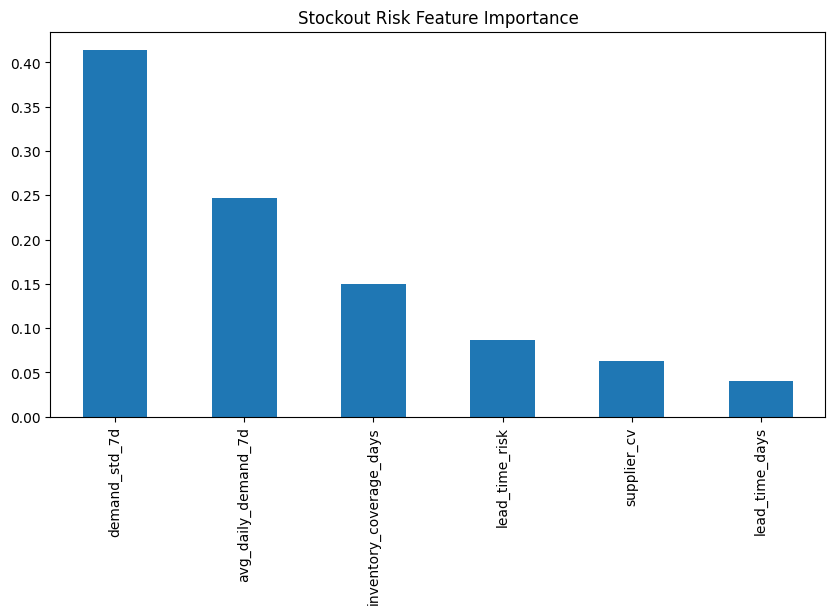

In [30]:
importances = pd.Series(
    so_model.feature_importances_,
    index=so_features
).sort_values(ascending=False)

importances.plot(kind="bar", figsize=(10,5))
plt.title("Stockout Risk Feature Importance")
plt.show()


## 9. Business Interpretation Outputs

In [31]:
risk_summary = (
    test_so.groupby("supplier_id")
    .agg(
        avg_stockout_risk=("stockout_risk_score", "mean"),
        stockout_rate=("stock_out_flag", "mean")
    )
    .sort_values("avg_stockout_risk", ascending=False)
)

risk_summary.head(10)


,avg_stockout_risk,stockout_rate
supplier_id,,
52,0.297274,0.032010
45,0.297224,0.029453
53,0.297057,0.035422
11,0.296627,0.023448
39,0.295115,0.034256
26,0.294385,0.023560
56,0.294221,0.030303
3,0.293719,0.029630
5,0.293178,0.030184


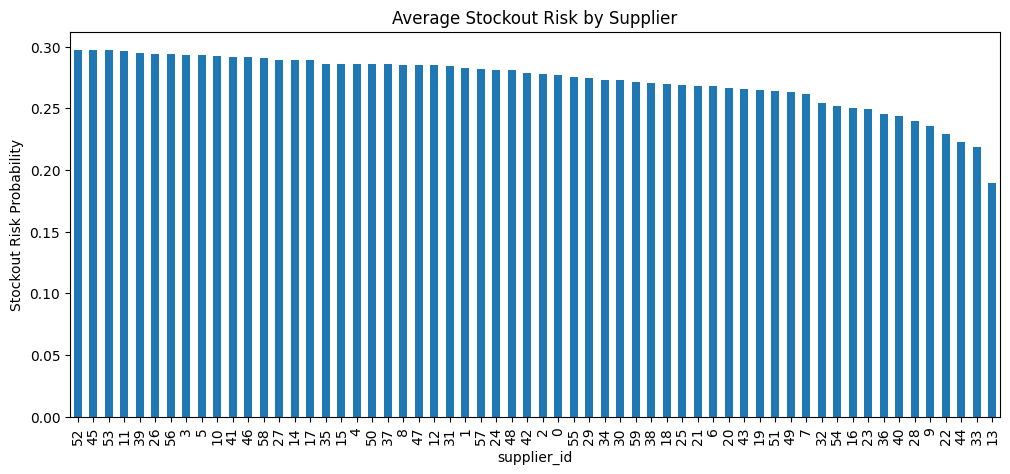

In [32]:
risk_summary["avg_stockout_risk"].plot(
    kind="bar", figsize=(12,5), title="Average Stockout Risk by Supplier"
)
plt.ylabel("Stockout Risk Probability")
plt.show()


## Final Interpretation (Example for supplier_id = 50)

Supplier 52 has the **highest risk of causing future stockouts** among all suppliers.

Even though stockouts have **not happened very often in the past**, the model shows that this supplier creates **unstable supply conditions**.


**What the numbers mean (in simple terms)**

* **Average stockout risk ≈ 0.29**

   * On many days, the system is **close to running out of stock** when this supplier is involved.

* **Stockout rate ≈ 3.2%**

  * Stockouts are rare, but when conditions worsen, they happen quickly.

This means the supply chain is fragile, not safe.


**Why this is happening**

For supplier 52:

* Delivery times are inconsistent

* Lead times change from order to order

* Inventory buffers are not enough to absorb these delays

So even small delays can cause stockouts.



**Why this is important**

Stockouts do not give early warnings.
By the time they happen, sales are already lost.

This risk score acts as an **early warning signal** and shows which supplier needs attention before problems occur.


**What should be done**

For supplier 52:

* Increase safety stock

* Review reorder points

* Monitor delivery delays closely

* Discuss performance in supply planning meetings